### **全コードのまとめ**

このプロジェクトは、**SMILES 文字列**を用いて化学構造を表現するモデルを訓練し、**新しい SMILES 文字列を生成する**ことを目的としたものです。以下のステップで全体の流れを解説します。

---

### **1. 必要なライブラリのインポート**

```python
import torch
import pandas as pd
from collections import Counter
import pickle
import matplotlib.pyplot as plt
import random
```

- **torch**：PyTorch（深層学習ライブラリ）を使用。
- **pandas**：CSV ファイルの読み込みやデータの操作を行う。
- **Counter**：単語の頻度カウントを行う。
- **pickle**：学習した損失（Loss）の履歴を保存・読み込み。
- **matplotlib.pyplot**：損失の履歴をグラフ化。
- **random**：ランダムに開始テキストを選ぶ。

---

### **2. データセットの読み込みと処理**
```python
class Dataset(torch.utils.data.Dataset):
    def __init__(self, url, smiles_col, sequence_length=4):
        self.url = url
        self.smiles_col = smiles_col
        self.sequence_length = sequence_length
        self.smiles = []
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()
        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}
        self.words_indexes = [self.word_to_index[w] for w in self.words]
```

- **Dataset クラス**：SMILES 文字列を読み込み、モデルが学習するために文字列をトークン化（単語のインデックス）する。
- `sequence_length=4`：LSTM に渡す文字列の長さを設定（4文字ごとに学習）。

---

### **3. LSTM モデルの定義**

```python
class LSTM_Generator(torch.nn.Module):
    def __init__(self, dataset):
        super(LSTM_Generator, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = torch.nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = torch.nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = torch.nn.Linear(self.lstm_size, n_vocab)
```

- **LSTM_Generator クラス**：LSTM モデルの構造を定義。
  - **埋め込み層**：入力された単語（文字）をベクトル空間に変換。
  - **LSTM 層**：時系列データ（文字列）を処理。
  - **全結合層**：最終的に SMILES の各文字に対する予測を行う。

---

### **4. 学習処理**

```python
def train(dataset, model):
    losses = []
    model.train()
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(MAX_EPOCHS):
        state_h, state_c = model.init_state(SEQUENCE_LENGTH)
        total_loss = 0

        for batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()
            y_pred, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(y_pred.transpose(1, 2), y)
            total_loss += loss.item()
            state_h = state_h.detach()
            state_c = state_c.detach()
            loss.backward()
            optimizer.step()

        print(f"Epoch: {epoch+1}, Loss: {total_loss:.3f}")
        losses.append(total_loss)

    return losses
```

- **train() 関数**：LSTM モデルをトレーニング。
  - **クロスエントロピー損失**：予測と実際の文字列の差を計算し、モデルを最適化。
  - **Adam オプティマイザ**：勾配に基づいてモデルのパラメータを更新。

---

### **5. モデル評価と SMILES 生成**

```python
def predict(dataset, model, text, next_words=50):
    words = [text[i] for i in range(len(text))]
    model.eval()

    state_h, state_c = model.init_state(len(words))

    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]])
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))

        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.index_to_word[word_index])

    return "".join(words)
```

- **predict() 関数**：モデルに与えられたテキストから、次の文字を生成し、新しい SMILES 文字列を生成。
  - 最初に与えた文字列（`text`）を基に **次の 50 文字**を予測。

---

### **6. 学習済みモデルの評価**

```python
generated_smiles = predict(dataset, model, text='C')
print(generated_smiles)
```

- **SMILES 生成**：`'C'` という文字を初期入力として、新しい SMILES 文字列を生成。
- 生成した SMILES 文字列を表示。

---

### **7. 損失履歴の可視化**

```python
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.show()
```

- 学習の損失（Loss）の履歴を **グラフ化** し、訓練中にモデルがどのように収束しているかを可視化。

---

### **8. 学習済みモデルと損失履歴の保存**

```python
torch.save(model.state_dict(), 'model_epoch200.pth')
with open('losses_epoch200.pkl', 'wb') as f:
    pickle.dump(losses, f)
```

- **モデルの保存**：学習済みのモデルを `.pth` ファイルとして保存。
- **損失履歴の保存**：`pickle` を使い、学習の損失履歴を保存。

---

### **全体の流れ**

1. **データセットの準備**：SMILES 文字列を読み込み、トークン化。
2. **LSTM モデルの定義**：文字列生成用の LSTM モデルを設計。
3. **モデルの学習**：データを使ってモデルを訓練し、損失を最小化。
4. **モデル評価と生成**：学習後、初期の SMILES 文字列を基に新しい SMILES 文字列を生成。
5. **損失の可視化**：学習過程をグラフ化し、収束状況を確認。

---

このプロジェクトは、化学構造を表現する SMILES 文字列を生成するモデルを学習し、新しい分子構造を生成するために利用できます！

In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 21.7 MB/s eta 0:00:00


`!pip install rdkit` のコードは、Pythonのパッケージマネージャー `pip` を使用して **RDKit** というライブラリをインストールするためのコマンドです。  

### **コードの解説**
1. `!`（エクスクラメーションマーク）:
   - Jupyter Notebook や Google Colab で実行する際に、シェルコマンド（ターミナルのコマンド）を実行するためのプレフィックスです。  
   - 通常のPythonスクリプトでは不要で、代わりに `pip install rdkit` を使います。

2. `pip install rdkit`:
   - Pythonのパッケージ管理ツール `pip` を使って **RDKit** をインストールします。  
   - **RDKit** は、化学情報学や分子モデリングに使用されるオープンソースのライブラリで、分子構造の解析、フィンガープリント生成、分子の可視化、化学的性質の計算などができます。

### **補足**
RDKitは通常の `pip install` では公式のPythonパッケージインデックス（PyPI）から直接インストールできないことが多く、代わりに **conda** を使ってインストールするのが一般的です。  
したがって、環境によっては以下の方法を試す必要があります。

#### **1. Condaを使ったインストール（推奨）**
```sh
conda install -c conda-forge rdkit
```
- `-c conda-forge` は、RDKitが提供されている `conda-forge` チャネルを指定するオプションです。

#### **2. Google Colabでのインストール**
Google Colabでは、以下のように `pip` ではなく `conda` を使う必要があります。
```sh
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c conda-forge rdkit -y
```

### **まとめ**
- `!pip install rdkit` はJupyter NotebookでRDKitをインストールする試みだが、環境によっては `pip` ではなく `conda` の使用が推奨される。
- RDKitは化学情報学や機械学習で分子構造を扱うのに便利なライブラリ。  
- Google Colabでは `conda-forge` からのインストールが必要。

RDKitを使って化学データを処理することに興味があるようですが、具体的にどのようなタスクに利用したいですか？

In [ ]:
from rdkit import Chem

def trim_smiles(smile):
    mol = mol_from_smiles(smile)
    while not mol:
        if len(smile) == 0: break
        smile = smile[:-1]
        mol = mol_from_smiles(smile)
    return smile


def mol_from_smiles(smile):
    try:
        mol = Chem.MolFromSmiles(smile)
        return mol
    except:
        return None

このコードは、RDKit を使って **SMILES 文字列**（分子の構造を表す文字列）を検証し、無効な部分を削りながら有効な SMILES を見つける処理を行います。  

---

## **コードの詳細**
### **1. `from rdkit import Chem`**
RDKitの `Chem` モジュールをインポートします。  
- `Chem.MolFromSmiles(smile)` を使うことで、**SMILES 文字列を分子オブジェクト（Mol）に変換**できます。  
- もしSMILESが無効な場合、`MolFromSmiles` は `None` を返します。

---

### **2. `mol_from_smiles(smile)` 関数**
この関数は、SMILES 文字列を **RDKit の分子オブジェクト** (`Mol`) に変換するラッパー関数です。

```python
def mol_from_smiles(smile):
    try:
        mol = Chem.MolFromSmiles(smile)
        return mol
    except:
        return None
```
- `Chem.MolFromSmiles(smile)` を使ってSMILESを `Mol` オブジェクトに変換する。
- 変換に失敗した場合（例外が発生した場合）、`None` を返す。

> **注意**: `Chem.MolFromSmiles(smile)` は通常例外を投げず、無効なSMILESなら単に `None` を返します。  
> したがって `try-except` はなくても問題ない場合が多いです。

---

### **3. `trim_smiles(smile)` 関数**
この関数は、SMILES 文字列の末尾から1文字ずつ削除しながら、**有効なSMILES** を見つける処理を行います。

```python
def trim_smiles(smile):
    mol = mol_from_smiles(smile)  # SMILESをMolに変換
    while not mol:  # 無効な場合はループ
        if len(smile) == 0:  # 空文字列になったら終了
            break
        smile = smile[:-1]  # 末尾を1文字削除
        mol = mol_from_smiles(smile)  # 再度Molに変換
    return smile  # 最後に有効なSMILESを返す
```

#### **処理の流れ**
1. `mol_from_smiles(smile)` を使って SMILES を Mol に変換する。
2. `Mol` オブジェクトが `None`（無効）なら、1文字ずつ削りながら再試行。
3. 有効な SMILES になった時点でループ終了し、残った部分を返す。

---

## **動作例**
### **入力例 1（有効なSMILES）**
```python
trim_smiles("CCO")  # エタノール
```
- `"CCO"` は有効なSMILES → そのまま返す。
- **出力:** `"CCO"`

---

### **入力例 2（無効なSMILESを含む）**
```python
trim_smiles("CCO123")
```
1. `"CCO123"` → 無効
2. `"CCO12"` → 無効
3. `"CCO1"` → 無効
4. `"CCO"` → **有効！**
5. **出力:** `"CCO"`

---

## **用途**
- **データクリーニング**:
  - 無効なSMILESを取り除き、最大限有効な部分を抽出する。
- **SMILESのフォーマットエラー修正**:
  - 間違った文字を含む場合に、できるだけ修正して解析を進める。

---

## **改善点**
### **1. `Chem.MolFromSmiles()` の `try-except` は不要**
RDKit の `MolFromSmiles` は、無効な SMILES に対して `None` を返すため、 `try-except` はなくても問題ありません。

### **2. `trim_smiles` の効率化**
- 末尾を削除するのではなく、`Chem.MolFromSmiles` による部分一致を使う方法も考えられる。
- 例えば、`Chem.SanitizeMol()` を使ってエラーをチェックしながら部分的に修正できる可能性がある。

---

## **まとめ**
- `trim_smiles(smile)` は、無効な SMILES の末尾を削りながら、有効な SMILES を探す関数。
- `mol_from_smiles(smile)` は、SMILES を `Mol` オブジェクトに変換する関数。
- RDKit を使って **化学データの前処理** や **エラーチェック** に役立つ。

このコードをどのような用途で使おうと考えていますか？

In [ ]:
import torch
import pandas as pd
from collections import Counter

class Dataset(torch.utils.data.Dataset):
    def __init__(self, url, smiles_col, sequence_length=4):
        self.url = url
        self.smiles_col = smiles_col
        self.sequence_length = sequence_length
        self.smiles = []
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()
        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}
        self.words_indexes = [self.word_to_index[w] for w in self.words]

    def load_words(self):
        train_df = pd.read_csv(self.url)
        self.smiles = list(train_df[self.smiles_col])
        text = train_df[self.smiles_col].str.cat(sep=' ')
        text = "".join(text.split(' '))
        return [text[i] for i in range(len(text))]

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.words_indexes) - self.sequence_length

    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index:index+self.sequence_length]),
            torch.tensor(self.words_indexes[index+1:index+self.sequence_length+1]),
        )

このコードは、SMILES 文字列を **時系列データ** として扱い、ニューラルネットワークの **データセット（PyTorch Dataset）** を作成するクラス `Dataset` を定義しています。  
  
### **コードの概要**
- **SMILESデータの読み込み**
- **各文字をトークンとして扱い、インデックスに変換**
- **シーケンスデータを作成し、次の文字を予測する形式に変換**
  
**主な用途:**  
このデータセットは、**SMILES 文字列を対象にした言語モデルの学習** に使用できます（例: RNN, LSTM, Transformer）。

---

## **コードの詳細**
### **1. 必要なライブラリのインポート**
```python
import torch
import pandas as pd
from collections import Counter
```
- `torch`: PyTorchのデータセット作成とテンソル処理用
- `pandas`: CSVデータの読み込み
- `Counter`: 文字の出現頻度をカウントし、ユニークな文字リストを作成するために使用

---

### **2. `Dataset` クラス**
PyTorch の `Dataset` クラスを継承して、独自のデータセットを定義。

```python
class Dataset(torch.utils.data.Dataset):
```

---

### **3. `__init__` メソッド（初期化処理）**
```python
def __init__(self, url, smiles_col, sequence_length=4):
```
- `url`: CSVファイルのURLまたはパス
- `smiles_col`: SMILES 文字列が含まれる列名
- `sequence_length`: 1つのデータに含まれる文字列の長さ（デフォルトは4）

**処理の流れ**
```python
self.smiles = []
self.words = self.load_words()  # SMILES 文字列を1文字ごとにリスト化
self.uniq_words = self.get_uniq_words()  # ユニークな文字のリストを取得
```
- `self.words`: SMILES 文字列を **1文字ごとのリスト** に変換  
- `self.uniq_words`: 文字の種類をユニークにしたリスト（出現頻度順）

```python
self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}
```
- **文字 → インデックス**
- **インデックス → 文字** の辞書を作成

```python
self.words_indexes = [self.word_to_index[w] for w in self.words]
```
- `self.words_indexes`: SMILES 文字を **インデックスのリスト** に変換

---

### **4. `load_words()`（SMILESを文字リストに変換）**
```python
def load_words(self):
    train_df = pd.read_csv(self.url)  # CSVデータの読み込み
    self.smiles = list(train_df[self.smiles_col])  # SMILESのリスト化
    text = train_df[self.smiles_col].str.cat(sep=' ')  # SMILESを連結
    text = "".join(text.split(' '))  # 空白を削除
    return [text[i] for i in range(len(text))]  # 1文字ずつリスト化
```
**処理の流れ**
1. CSVデータを `pandas` で読み込む
2. 指定された列の SMILES をリストに保存
3. すべての SMILES を結合し、**1つの長い文字列** にする
4. 空白を削除
5. 文字列を1文字ずつリストに変換

**例**
```python
# CSVデータ
smiles_col = ["CCO", "C=O", "NCCO"]
# 結果
text = "CCOC=ONCCO"
words = ["C", "C", "O", "C", "=", "O", "N", "C", "C", "O"]
```

---

### **5. `get_uniq_words()`（ユニークな文字を取得）**
```python
def get_uniq_words(self):
    word_counts = Counter(self.words)  # 文字の頻度をカウント
    return sorted(word_counts, key=word_counts.get, reverse=True)  # 出現頻度順にソート
```
- `Counter` で文字ごとの出現回数を取得
- 出現回数の多い順にソートして、ユニークな文字リストを作成

---

### **6. `__len__()`（データセットの長さを取得）**
```python
def __len__(self):
    return len(self.words_indexes) - self.sequence_length
```
- `self.words_indexes` の長さから `sequence_length` を引いたものがデータ数
- 例えば `words_indexes = [0, 1, 2, 3, 4]` で `sequence_length=2` の場合:
  - `len(words_indexes) = 5`
  - `データ数 = 5 - 2 = 3`
  - **データの組み合わせ**
    1. `[0, 1] → [1, 2]`
    2. `[1, 2] → [2, 3]`
    3. `[2, 3] → [3, 4]`

---

### **7. `__getitem__()`（データの取得）**
```python
def __getitem__(self, index):
    return (
        torch.tensor(self.words_indexes[index:index+self.sequence_length]),
        torch.tensor(self.words_indexes[index+1:index+self.sequence_length+1]),
    )
```
- 入力データ: `index` から `index+sequence_length` までの文字インデックス
- ラベルデータ: `index+1` から `index+sequence_length+1` までの文字インデックス

**例**
```python
words_indexes = [0, 1, 2, 3, 4]
sequence_length = 2

index = 0
入力データ:  [0, 1]
ラベルデータ: [1, 2]

index = 1
入力データ:  [1, 2]
ラベルデータ: [2, 3]
```

**用途**
- **言語モデル（次の文字の予測）**
- **RNN, LSTM, Transformer の学習データ**

---

## **まとめ**
| メソッド | 役割 |
|----------|------|
| `load_words()` | CSVからSMILESを取得し、1文字ずつリスト化 |
| `get_uniq_words()` | 文字の出現頻度順でユニークなリストを作成 |
| `__len__()` | データセットのサイズを返す |
| `__getitem__()` | 入力とラベルのペアを作成（時系列データ） |

**このデータセットは、SMILES 文字列を対象にした「次の文字を予測するモデル」に使えます。**  
例えば、RNN や Transformer を用いた **SMILES 生成** モデルを作ることができます。  

このコードをどのような用途に使おうと考えていますか？ 🚀

In [ ]:
import torch

class LSTM_Generator(torch.nn.Module):
    def __init__(self, dataset):
        super(LSTM_Generator, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = torch.nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = torch.nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = torch.nn.Linear(self.lstm_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)

        return logits, state

    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))


このコードは、**LSTM を用いた SMILES 文字列の生成モデル** を実装したものです。  
PyTorch を使い、ニューラルネットワーク (`torch.nn.Module` のサブクラス) として `LSTM_Generator` を定義しています。  

---

## **コードの概要**
| 要素 | 説明 |
|------|------|
| **モデルの目的** | SMILES の文字列生成（次の文字を予測する言語モデル） |
| **入力データ** | SMILES 文字列のインデックス（整数配列） |
| **出力データ** | 各時間ステップでの次の文字の確率分布 |
| **使用する層** | 埋め込み層 (`Embedding`), LSTM (`LSTM`), 全結合層 (`Linear`) |
| **学習対象** | SMILES の次の文字を予測するために LSTM を学習 |

---

## **1. `__init__()`（モデルの初期化）**
```python
class LSTM_Generator(torch.nn.Module):
    def __init__(self, dataset):
        super(LSTM_Generator, self).__init__()
```
- `torch.nn.Module` を継承してニューラルネットワークを定義。
- `dataset` は `Dataset` クラスのインスタンス（データセットオブジェクト）。

### **(1) ハイパーパラメータの設定**
```python
self.lstm_size = 128       # LSTMの隠れ層のサイズ
self.embedding_dim = 128   # 埋め込み層の次元数
self.num_layers = 3        # LSTMの層の数
```
- LSTMのサイズ (`hidden_size`) や層の数 (`num_layers`) を定義。

### **(2) 語彙サイズ（n_vocab）の取得**
```python
n_vocab = len(dataset.uniq_words)
```
- `dataset.uniq_words` には、SMILES に登場する **ユニークな文字のリスト** が格納されている。
- その長さを `n_vocab` として、**語彙サイズ（ユニークなトークンの数）** とする。

### **(3) 埋め込み層（Embedding）**
```python
self.embedding = torch.nn.Embedding(
    num_embeddings=n_vocab,
    embedding_dim=self.embedding_dim,
)
```
- `Embedding` 層は **文字（インデックス）をベクトルに変換** する層。
- `num_embeddings=n_vocab`: 語彙のサイズ（文字の種類数）
- `embedding_dim=self.embedding_dim`: 埋め込みベクトルの次元数（128）

### **(4) LSTM層**
```python
self.lstm = torch.nn.LSTM(
    input_size=self.lstm_size,  # 入力の特徴量の次元数
    hidden_size=self.lstm_size,  # LSTMの隠れ状態の次元数
    num_layers=self.num_layers,  # LSTMの層の数
    dropout=0.2,                 # ドロップアウト率（過学習防止）
)
```
- `LSTM` は**系列データを処理するRNNの一種**。
- `input_size = self.lstm_size`: 入力の次元（通常 `embedding_dim` にすべきだが、`lstm_size` になっている）。
- `hidden_size = self.lstm_size`: 隠れ層のサイズ。
- `num_layers = self.num_layers`: LSTM の層数（3層）。
- `dropout=0.2`: 過学習を防ぐためのドロップアウト（0.2 = 20%）。

### **(5) 全結合層（Linear）**
```python
self.fc = torch.nn.Linear(self.lstm_size, n_vocab)
```
- `LSTM` の出力を、次の文字の確率分布（`n_vocab` のサイズ）に変換するための **全結合層**。

---

## **2. `forward()`（順伝播）**
```python
def forward(self, x, prev_state):
```
- `x`: **入力シーケンス（インデックスのテンソル）**
- `prev_state`: **前の LSTM の隠れ状態（h, c）**

### **(1) 埋め込み層でベクトル変換**
```python
embed = self.embedding(x)
```
- `x`（インデックスのテンソル）を `embedding` 層に通して、**埋め込みベクトル** に変換。
- `embed.shape = (batch_size, sequence_length, embedding_dim)`

### **(2) LSTM に入力**
```python
output, state = self.lstm(embed, prev_state)
```
- `embed` を LSTM に入力。
- `output`: LSTM の出力（各時刻の隠れ状態）。
- `state`: 次の時刻に渡す LSTM の内部状態 `(h, c)`。

**出力の形状**
- `output.shape = (batch_size, sequence_length, lstm_size)`

### **(3) 全結合層を通して次の文字の確率を計算**
```python
logits = self.fc(output)
```
- `output` を `fc` 層に通し、各時刻での **次の文字のスコア（ロジット）** を計算。
- `logits.shape = (batch_size, sequence_length, n_vocab)`

### **(4) ロジットと状態を返す**
```python
return logits, state
```
- **`logits`（次の文字の確率分布）**
- **`state`（次の時刻に渡す LSTM の隠れ状態）**

---

## **3. `init_state()`（LSTMの初期状態を作成）**
```python
def init_state(self, sequence_length):
    return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
            torch.zeros(self.num_layers, sequence_length, self.lstm_size))
```
- LSTM の初期状態 `(h_0, c_0)` を **ゼロベクトル** で初期化。
- `num_layers`: LSTM の層数
- `sequence_length`: 入力のシーケンス長
- `lstm_size`: 隠れ状態のサイズ（128）

---

## **動作イメージ**
1. **データの準備**
   ```python
   dataset = Dataset("data.csv", smiles_col="SMILES")
   ```
2. **モデルの作成**
   ```python
   model = LSTM_Generator(dataset)
   ```
3. **初期状態の作成**
   ```python
   state = model.init_state(sequence_length=4)
   ```
4. **ダミー入力データ（文字列インデックス）**
   ```python
   x = torch.randint(0, len(dataset.uniq_words), (1, 4))  # 例: [[1, 5, 9, 3]]
   ```
5. **モデルの順伝播**
   ```python
   logits, new_state = model(x, state)
   ```

---

## **まとめ**
| コンポーネント | 説明 |
|--------------|------|
| **Embedding 層** | 文字インデックスをベクトルに変換 |
| **LSTM 層** | シーケンスデータを処理し、次の文字を予測 |
| **全結合層 (FC)** | 各時間ステップでの次の文字の確率分布を出力 |
| **init_state()** | LSTM の隠れ状態を初期化 |
| **forward()** | 順伝播を実行し、次の文字の予測を行う |

このモデルを使うことで、**SMILES の次の文字を予測し、新しい化合物のSMILESを生成する**ことができます。  
LSTM を Transformer に変更することで、より高性能なモデルを作成することも可能です。

この LSTM モデルをどのように活用したいですか？ 😊

In [ ]:
def predict(dataset, model, text, next_words=50):
    words = [text[i] for i in range(len(text))]
    model.eval()

    state_h, state_c = model.init_state(len(words))

    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]])
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))

        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.index_to_word[word_index])

    return trim_smiles("".join(words))

このコードは、**LSTMモデルを用いたSMILES文字列の自動生成（次の文字予測）** を行う関数 `predict()` です。  
以下のような動作をします。

1. **初期入力文字列 (`text`) から始める**
2. **LSTMを使って次の文字を予測**
3. **確率分布に基づいてランダムに文字を選択**
4. **選ばれた文字を追加し、次の入力として再度予測**
5. **指定された長さ (`next_words`) まで繰り返す**
6. **最終的なSMILESをトリミングして返す**

---

## **コードの詳細な解説**
### **1. 関数の定義**
```python
def predict(dataset, model, text, next_words=50):
```
- `dataset`: **学習済みのデータセット**
  - `word_to_index`（文字→インデックスの辞書）や `index_to_word`（インデックス→文字の辞書）を持つ。
- `model`: **学習済みの LSTM モデル**
- `text`: **予測を開始する初期の SMILES 文字列**
- `next_words`: **生成する追加の文字数（デフォルト50）**

---

### **2. 初期文字の準備**
```python
words = [text[i] for i in range(len(text))]
```
- `text` の各文字をリストに分解し、`words` に格納。

---

### **3. モデルを推論モードに設定**
```python
model.eval()
```
- `model.eval()` を呼ぶことで、**推論モード** に変更。
- `Dropout` や `BatchNorm` などの動作が訓練時とは異なるため、推論時には `eval()` が必要。

---

### **4. LSTM の初期状態を作成**
```python
state_h, state_c = model.init_state(len(words))
```
- `model.init_state(len(words))` を使って **LSTMの隠れ状態 (`h`, `c`) をゼロベクトルで初期化**。
- `state_h, state_c` は LSTM に入力される**隠れ状態（hidden state）とセル状態（cell state）**。

---

### **5. 文字を順次生成**
```python
for i in range(0, next_words):
```
- 指定された `next_words`（50文字）の間、**次の文字を予測** し続ける。

#### **(1) 入力データの作成**
```python
x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]])
```
- `words[i:]` の部分列を使って **インデックスのリスト** を作成し、テンソル化。
- 例: `"CCO"` → `[word_to_index['C'], word_to_index['C'], word_to_index['O']]`

#### **(2) LSTM に入力**
```python
y_pred, (state_h, state_c) = model(x, (state_h, state_c))
```
- LSTM に現在の `x`（入力文字列のインデックス列）と `state_h, state_c`（前の隠れ状態）を渡す。
- `y_pred`: LSTM の出力（次の文字のロジット）。
- `state_h, state_c`: 更新された隠れ状態。

---

### **6. 次の文字を選択**
```python
last_word_logits = y_pred[0][-1]
```
- `y_pred` の最終時刻の出力（最新の文字に対応するロジット）を取得。
- `last_word_logits.shape = (n_vocab,)` （各文字のスコアが含まれる）。

#### **(1) 確率分布の計算**
```python
p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()
```
- `softmax` を適用し、各文字の確率を計算。
- `.detach().numpy()` を使い、**計算グラフから切り離して NumPy 配列に変換**。

#### **(2) 確率に基づいてランダムに文字を選択**
```python
word_index = np.random.choice(len(last_word_logits), p=p)
```
- `np.random.choice()` を使って、確率 `p` に基づき次の文字のインデックスをランダムに選択。
- **確率の高い文字ほど選ばれやすい** が、確率的にランダムな要素もある。

#### **(3) 選ばれた文字を `words` に追加**
```python
words.append(dataset.index_to_word[word_index])
```
- `index_to_word` を使い、インデックスから文字に変換してリストに追加。

---

### **7. 生成されたSMILESをトリミング**
```python
return trim_smiles("".join(words))
```
- 予測された文字列を結合して SMILES 文字列を作成。
- `trim_smiles()` を適用し、**無効な部分を削除** して **化学的に妥当な SMILES に整える**。

---

## **全体の流れ**
1. **最初の文字列 (`text`) を用意**
2. **LSTM の初期状態を作成**
3. **次の `next_words` 文字を逐次生成**
   - **LSTM に入力し、次の文字を予測**
   - **確率分布を計算し、ランダムに文字を選択**
   - **選択した文字を `words` に追加**
4. **最終的な SMILES を整えて出力**

---

## **例: 動作イメージ**
```python
dataset = Dataset("data.csv", smiles_col="SMILES")
model = LSTM_Generator(dataset)
text = "CCO"

generated_smiles = predict(dataset, model, text, next_words=10)
print(generated_smiles)
```
### **実行結果（例）**
```
CCOCCN(CC)
```
- `"CCO"` から始まり、10文字が追加され、**有機化合物のSMILESが生成** される。

---

## **まとめ**
| 処理 | 説明 |
|------|------|
| **モデルの初期化** | `eval()` に設定 |
| **LSTM の初期状態を作成** | `init_state()` を使用 |
| **文字列をインデックスに変換** | `word_to_index` を用いる |
| **LSTM で次の文字を予測** | `model(x, state)` |
| **確率分布から文字を選択** | `softmax` を適用し `np.random.choice()` |
| **文字列をトリミング** | `trim_smiles()` で不正な部分を除去 |

---

## **応用: さらなる改良**
1. **より高精度な予測**
   - `np.random.choice()` を使わず、`argmax()` にすると**決定論的な予測** になる。
   - `temperature`（温度パラメータ）を導入し、**多様性を制御** できる。
   
2. **Transformer に変更**
   - LSTM ではなく、`Transformer` を使うと**より長距離の依存関係を学習** 可能。

3. **生成後の構造評価**
   - RDKit を用いて、**生成されたSMILESの化学的妥当性をチェック** する。

---

この関数をどのように活用したいですか？  
例えば、**新しい化合物のデザイン** や **特定のパターンを持つSMILESの生成** など、用途に応じてカスタマイズも可能です！ 😊

In [ ]:
import random

def get_best_smiles(dataset, model, next_words=100, max_trial=10, start_length=3):
    best_smile = ""
    for trial in range(max_trial):
        starting_text = random.choice(dataset.smiles)[:start_length]
        smile = predict(dataset, model, text=starting_text, next_words=next_words)
        if len(best_smile) < len(smile):
            best_smile = smile
    return best_smile

このコードは、**LSTM モデルを用いた SMILES 文字列の生成を試行し、最も長いものを選択する** 関数 `get_best_smiles()` です。  

---

## **コードの詳細な解説**
### **1. 関数の定義**
```python
def get_best_smiles(dataset, model, next_words=100, max_trial=10, start_length=3):
```
- `dataset`: **SMILES 文字列のデータセット**（`Dataset` クラスのインスタンス）
- `model`: **LSTM を用いた文字生成モデル**（`LSTM_Generator` クラスのインスタンス）
- `next_words`: **生成する追加の文字数（デフォルト100）**
- `max_trial`: **異なるランダムな開始文字列で試行する回数（デフォルト10）**
- `start_length`: **開始文字列の長さ（デフォルト3）**
  - ランダムに選んだSMILESから `start_length` 文字分を取り出し、生成の起点とする。

---

### **2. 最良の SMILES を格納する変数を初期化**
```python
best_smile = ""
```
- `best_smile` には、**現在の最も長いSMILES文字列を格納** する。

---

### **3. 指定された回数 (`max_trial`) だけ試行**
```python
for trial in range(max_trial):
```
- `max_trial` 回（デフォルト 10回）ループを実行し、**異なる開始文字列からSMILESを生成** する。

---

### **4. ランダムな開始文字列を取得**
```python
starting_text = random.choice(dataset.smiles)[:start_length]
```
- `dataset.smiles` から**ランダムに1つSMILESを選択**。
- その最初の `start_length` 文字（デフォルト3文字）を取得し、**開始文字列** とする。

  **例:**
  ```python
  dataset.smiles = ["CCO", "CNC=O", "CCCBr"]
  start_length = 3
  ```
  - `random.choice(dataset.smiles)` → `"CNC=O"`
  - `starting_text = "CNC"`

---

### **5. `predict()` を用いてSMILESを生成**
```python
smile = predict(dataset, model, text=starting_text, next_words=next_words)
```
- `predict()` 関数を使い、LSTM に `starting_text` を与えて **次の `next_words` 文字（デフォルト100文字）を生成** する。

  **例:**
  ```python
  starting_text = "CNC"
  generated_smile = predict(dataset, model, text="CNC", next_words=100)
  ```
  - 予測されたSMILES → `"CNC(=O)CCNCCO..."`

---

### **6. 現在の `best_smile` と比較して、長ければ更新**
```python
if len(best_smile) < len(smile):
    best_smile = smile
```
- `smile` の長さが `best_smile` よりも長い場合、`best_smile` を更新。
  - これにより、**より長いSMILESを採用** する。

---

### **7. 最終的な最長のSMILESを返す**
```python
return best_smile
```
- `max_trial` 回の試行が終わった後、最も長いSMILESを返す。

---

## **全体の流れ**
1. **ランダムにSMILESを選ぶ**
2. **最初の `start_length` 文字を取り出す**
3. **その文字列から SMILES を生成**
4. **最も長い SMILES を保持**
5. **最良のSMILESを返す**

---

## **実行例**
```python
dataset = Dataset("data.csv", smiles_col="SMILES")
model = LSTM_Generator(dataset)

best_smiles = get_best_smiles(dataset, model)
print(best_smiles)
```

### **出力例**
```
CCOCCN(CC)C(=O)OCCOCC
```
- 10回試行し、最も長い有効なSMILESが選ばれる。

---

## **改良のポイント**
1. **化学的妥当性の確認**
   - 生成された SMILES が **RDKit で妥当な化学構造になるかチェック** する。
   ```python
   from rdkit import Chem
   if Chem.MolFromSmiles(smile) is not None:
       valid_smiles.append(smile)
   ```
   
2. **長さだけでなく、特定の性質を考慮**
   - **分子量** や **官能基の有無** を考慮して最良のSMILESを選択できる。

3. **探索の多様性を向上**
   - `random.choice(dataset.smiles)` だけでなく、**温度パラメータを使った予測** などで多様性を増やせる。

---

## **まとめ**
| 処理 | 説明 |
|------|------|
| **ランダムにSMILESを選択** | `random.choice(dataset.smiles)[:start_length]` |
| **LSTMを使って次の文字を予測** | `predict(dataset, model, text, next_words)` |
| **最も長いSMILESを保持** | `if len(best_smile) < len(smile): best_smile = smile` |
| **最終的な最長のSMILESを返す** | `return best_smile` |

この関数は **より長い（おそらく複雑な）SMILESを生成する** ための戦略として機能します！

In [ ]:
import torch
import numpy as np

def train(dataset, model):
    losses = []
    model.train()

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(MAX_EPOCHS):
        state_h, state_c = model.init_state(SEQUENCE_LENGTH)
        total_loss = 0

        for batch, (x, y) in enumerate(dataloader):

            optimizer.zero_grad()

            y_pred, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(y_pred.transpose(1, 2), y)
            total_loss += loss.item()

            state_h = state_h.detach()
            state_c = state_c.detach()

            loss.backward()
            optimizer.step()

        print("Epoch: {}, Loss: {:.3f}, Generated SMILES: {}".format(
            epoch+1,
            total_loss,
            get_best_smiles(dataset, model)
            )
        )
        losses.append(total_loss)
    return losses

このコードは、**LSTM を用いた SMILES 文字列の生成モデルの学習** を行う関数 `train()` です。  

---

## **コードの詳細な解説**
### **1. 関数の定義**
```python
def train(dataset, model):
```
- `dataset`: **学習データ**（`Dataset` クラスのインスタンス）
- `model`: **LSTM モデル**（`LSTM_Generator` クラスのインスタンス）

---

### **2. 学習モードに設定**
```python
losses = []
model.train()
```
- `model.train()` を呼び出して、PyTorch の学習モードに設定。
- `losses` リストを作成し、各エポックの損失を記録。

---

### **3. データローダーの作成**
```python
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)
```
- `torch.utils.data.DataLoader` を使用し、**バッチ単位でデータをロード** する。
- `BATCH_SIZE` はグローバル変数として定義されているはず。

---

### **4. 損失関数と最適化アルゴリズムの定義**
```python
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
```
- `CrossEntropyLoss()`: **多クラス分類用の損失関数**（単語の確率分布を学習するため）。
- `Adam`: **勾配降下法の一種である Adam 最適化アルゴリズム** を使用。
- `LEARNING_RATE` はグローバル変数として設定。

---

### **5. 学習ループの開始**
```python
for epoch in range(MAX_EPOCHS):
```
- `MAX_EPOCHS`（グローバル変数）で指定した回数だけ**モデルを学習** する。

---

### **6. LSTM の隠れ状態 (`state_h`, `state_c`) を初期化**
```python
state_h, state_c = model.init_state(SEQUENCE_LENGTH)
total_loss = 0
```
- `model.init_state(SEQUENCE_LENGTH)` で **LSTM の隠れ状態を初期化** する。
- `total_loss` を 0 にリセット（このエポックの合計損失を記録するため）。

---

### **7. バッチ単位で学習**
```python
for batch, (x, y) in enumerate(dataloader):
```
- `DataLoader` から **バッチ単位でデータ (`x`, `y`) を取得** する。
  - `x`: 入力データ（文字列のインデックス列）
  - `y`: 正解ラベル（`x` の次の文字）

---

### **8. 勾配をリセット**
```python
optimizer.zero_grad()
```
- **前回の勾配をリセット** し、新しい勾配を計算できるようにする。

---

### **9. LSTM にデータを入力し、予測値を取得**
```python
y_pred, (state_h, state_c) = model(x, (state_h, state_c))
```
- LSTM に `x` を入力し、**予測 `y_pred` と次の隠れ状態 `(state_h, state_c)` を取得**。

---

### **10. 損失の計算**
```python
loss = criterion(y_pred.transpose(1, 2), y)
total_loss += loss.item()
```
- `y_pred` の次元を `(batch_size, vocab_size, sequence_length)` に変換するために `.transpose(1, 2)` を適用。
- `CrossEntropyLoss` を適用し、損失を `total_loss` に加算。

---

### **11. 隠れ状態の切り離し**
```python
state_h = state_h.detach()
state_c = state_c.detach()
```
- **`detach()` を適用することで、計算グラフを切り離し**、メモリ使用量を削減。

---

### **12. 勾配の計算と最適化**
```python
loss.backward()
optimizer.step()
```
- `loss.backward()`: **誤差逆伝播（バックプロパゲーション）** を実行し、各パラメータの勾配を計算。
- `optimizer.step()`: **パラメータを更新** して、損失を減らすようにモデルを改善。

---

### **13. エポックごとのログ出力**
```python
print("Epoch: {}, Loss: {:.3f}, Generated SMILES: {}".format(
    epoch+1,
    total_loss,
    get_best_smiles(dataset, model)
    )
)
```
- **エポックごとに損失 (`total_loss`) と生成された SMILES を出力** する。

---

### **14. 損失を記録**
```python
losses.append(total_loss)
```
- 各エポックの合計損失を `losses` リストに保存。

---

### **15. 最終的な損失リストを返す**
```python
return losses
```
- **全エポック分の損失をリストとして返す**。

---

## **全体の流れ**
1. **データローダーを作成**
2. **損失関数と最適化アルゴリズムを定義**
3. **エポックごとに学習を実行**
   - LSTM の状態を初期化
   - バッチごとに予測と損失計算
   - 勾配をリセット、誤差逆伝播、パラメータ更新
   - 損失を記録
   - 生成された SMILES を出力
4. **損失のリストを返す**

---

## **実行例**
```python
dataset = Dataset("data.csv", smiles_col="SMILES")
model = LSTM_Generator(dataset)

losses = train(dataset, model)
```

### **出力例**
```
Epoch: 1, Loss: 23.450, Generated SMILES: CCOCCN
Epoch: 2, Loss: 21.873, Generated SMILES: CNC(=O)O
Epoch: 3, Loss: 19.420, Generated SMILES: CCCBr
...
```

---

## **改良のポイント**
1. **学習率スケジューリング**
   - `torch.optim.lr_scheduler` を使って、エポックが進むにつれて学習率を減少させる。
   ```python
   scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
   scheduler.step()
   ```

2. **勾配クリッピング**
   - `torch.nn.utils.clip_grad_norm_()` を使い、大きな勾配を抑えて学習を安定化。
   ```python
   torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
   ```

3. **より高度なデータ前処理**
   - SMILES のトークン化を改善し、より意味のある単位で処理する。

---

## **まとめ**
| 処理 | 説明 |
|------|------|
| **データローダー作成** | `DataLoader(dataset, batch_size=BATCH_SIZE)` |
| **損失関数と最適化手法の定義** | `CrossEntropyLoss()` + `Adam(model.parameters())` |
| **エポックごとに学習** | `for epoch in range(MAX_EPOCHS):` |
| **バッチ単位で処理** | `for batch, (x, y) in enumerate(dataloader):` |
| **LSTM に入力を与えて予測** | `y_pred, (state_h, state_c) = model(x, (state_h, state_c))` |
| **損失計算** | `loss = criterion(y_pred.transpose(1, 2), y)` |
| **バックプロパゲーション** | `loss.backward()` |
| **パラメータ更新** | `optimizer.step()` |
| **学習の進行状況を表示** | `print("Epoch: {}, Loss: {:.3f}, Generated SMILES: {}".format(...))` |

この `train()` 関数は、LSTM を使った **SMILES 文字列の生成モデルを学習させるための基本的なトレーニングループ** になっています！ 🚀

In [ ]:
import os
import pickle
import torch

def train(dataset, model):
    losses = []
    model.train()

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(MAX_EPOCHS):
        state_h, state_c = model.init_state(SEQUENCE_LENGTH)
        total_loss = 0

        for batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()

            y_pred, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(y_pred.transpose(1, 2), y)
            total_loss += loss.item()

            state_h = state_h.detach()
            state_c = state_c.detach()

            loss.backward()
            optimizer.step()

        print("Epoch: {}, Loss: {:.3f}, Generated SMILES: {}".format(
            epoch+1,
            total_loss,
            get_best_smiles(dataset, model)
            )
        )

        # Add the total loss to the list of losses
        losses.append(total_loss)

        # Save the model and loss history
        torch.save(model.state_dict(), '/content/drive/My Drive/day6/model_epoch{}.pth'.format(epoch+1))
        with open('/content/drive/My Drive/day6/losses_epoch{}.pkl'.format(epoch+1), 'wb') as f:
            pickle.dump(losses, f)

    return losses

このコードは、**LSTM を用いた SMILES 文字列生成モデルの学習** を行う関数 `train()` で、前回の `train()` に **モデルの保存機能** が追加されています。  

---

## **追加された機能**
- **学習過程でのモデル保存** (`torch.save`)
- **損失履歴の保存** (`pickle.dump`)

---

## **コードの詳細な解説**
### **1. 必要なライブラリのインポート**
```python
import os
import pickle
import torch
```
- `os`: ファイルパスの操作のために使用。
- `pickle`: **Python オブジェクトを保存・読み込み** するために使用。
- `torch`: PyTorch の機械学習フレームワーク。

---

### **2. 関数の定義**
```python
def train(dataset, model):
```
- `dataset`: **学習データ**（`Dataset` クラスのインスタンス）
- `model`: **LSTM モデル**（`LSTM_Generator` クラスのインスタンス）

---

### **3. 学習モードの設定**
```python
losses = []
model.train()
```
- `model.train()` を呼び出して、**PyTorch の学習モードに設定** する。
- `losses` リストを作成し、**各エポックの損失を記録** する。

---

### **4. データローダーの作成**
```python
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)
```
- `torch.utils.data.DataLoader` を使い、**データをバッチ単位でロード** する。
- `BATCH_SIZE` はグローバル変数。

---

### **5. 損失関数と最適化アルゴリズムの設定**
```python
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
```
- **損失関数**: `CrossEntropyLoss()`（多クラス分類向け）。
- **最適化手法**: `Adam`（勾配降下法の一種）。
- `LEARNING_RATE` は学習率（グローバル変数）。

---

### **6. 学習ループの開始**
```python
for epoch in range(MAX_EPOCHS):
```
- `MAX_EPOCHS`（グローバル変数）だけ学習を繰り返す。

---

### **7. LSTM の隠れ状態 (`state_h`, `state_c`) を初期化**
```python
state_h, state_c = model.init_state(SEQUENCE_LENGTH)
total_loss = 0
```
- `SEQUENCE_LENGTH`（グローバル変数）を用いて、**LSTM の隠れ状態を初期化** する。
- `total_loss` を 0 にリセット（エポックごとの損失を記録）。

---

### **8. バッチ単位で学習**
```python
for batch, (x, y) in enumerate(dataloader):
    optimizer.zero_grad()
```
- `x`（入力）と `y`（正解ラベル）を `dataloader` から取得。
- **前回の勾配をリセット** し、新しい勾配を計算できるようにする。

---

### **9. LSTM で予測値を計算**
```python
y_pred, (state_h, state_c) = model(x, (state_h, state_c))
```
- LSTM に `x` を入力し、**予測 `y_pred` と次の隠れ状態 `(state_h, state_c)` を取得**。

---

### **10. 損失を計算**
```python
loss = criterion(y_pred.transpose(1, 2), y)
total_loss += loss.item()
```
- `y_pred.transpose(1, 2)`: `CrossEntropyLoss` に適した形 `(batch_size, vocab_size, sequence_length)` に変換。
- 損失 `loss` を計算し、`total_loss` に加算。

---

### **11. 隠れ状態の切り離し**
```python
state_h = state_h.detach()
state_c = state_c.detach()
```
- **`detach()` を適用して計算グラフを切り離し**、メモリ使用量を削減。

---

### **12. 勾配の計算と最適化**
```python
loss.backward()
optimizer.step()
```
- `loss.backward()`: **誤差逆伝播（バックプロパゲーション）** を実行。
- `optimizer.step()`: **パラメータを更新** して、損失を減らす。

---

### **13. エポックごとのログ出力**
```python
print("Epoch: {}, Loss: {:.3f}, Generated SMILES: {}".format(
    epoch+1,
    total_loss,
    get_best_smiles(dataset, model)
    )
)
```
- エポックごとに損失 (`total_loss`) と**生成された SMILES を出力**。

---

### **14. 損失を記録**
```python
losses.append(total_loss)
```
- 各エポックの合計損失を `losses` リストに保存。

---

### **15. モデルと損失履歴の保存**
```python
torch.save(model.state_dict(), '/content/drive/My Drive/day6/model_epoch{}.pth'.format(epoch+1))
```
- **学習済みのモデルのパラメータ** を Google Drive に保存。
- `torch.save(model.state_dict(), filename)`: `state_dict()` を保存し、後で `model.load_state_dict()` で復元可能。

```python
with open('/content/drive/My Drive/day6/losses_epoch{}.pkl'.format(epoch+1), 'wb') as f:
    pickle.dump(losses, f)
```
- `pickle.dump(losses, f)`: **損失履歴を保存** し、学習の推移を後で確認可能。

---

### **16. 最終的な損失リストを返す**
```python
return losses
```
- 全エポック分の損失をリストとして返す。

---

## **全体の流れ**
1. **データローダーを作成**
2. **損失関数と最適化手法の定義**
3. **エポックごとに学習**
   - LSTM の隠れ状態を初期化
   - バッチごとに予測と損失計算
   - 勾配をリセット、誤差逆伝播、パラメータ更新
   - 損失を記録
   - 生成された SMILES を出力
   - **モデルと損失履歴を保存**
4. **損失のリストを返す**

---

## **実行例**
```python
dataset = Dataset("data.csv", smiles_col="SMILES")
model = LSTM_Generator(dataset)

losses = train(dataset, model)
```

### **出力例**
```
Epoch: 1, Loss: 23.450, Generated SMILES: CCOCCN
Epoch: 2, Loss: 21.873, Generated SMILES: CNC(=O)O
Epoch: 3, Loss: 19.420, Generated SMILES: CCCBr
...
```

---

## **改良のポイント**
1. **Google Drive のディレクトリチェック**
   ```python
   os.makedirs('/content/drive/My Drive/day6', exist_ok=True)
   ```
   - 保存先のディレクトリが存在しない場合に作成。

2. **モデルの定期的な保存**
   - 5 エポックごとに保存するように変更：
   ```python
   if (epoch+1) % 5 == 0:
       torch.save(model.state_dict(), 'model_epoch{}.pth'.format(epoch+1))
   ```

---

## **まとめ**
この `train()` 関数は、**LSTM による SMILES 生成モデルの学習を行いながら、モデルと損失履歴を Google Drive に保存するように設計** されています！ 🚀

In [ ]:
# Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


このコードは、Google Colab で **Google Drive をマウント** するためのものです。

---

## **コードの解説**
```python
# Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')
```

### **1. `from google.colab import drive`**
- `google.colab` モジュールから `drive` をインポート。
- Google Colab で **Google Drive の操作を可能にするライブラリ**。

### **2. `drive.mount('/content/drive')`**
- **Google Drive を `/content/drive` にマウント** する。
- 実行すると、**Google アカウントの認証を求めるプロンプトが表示** される。
- 認証後、Google Drive 内のファイルにアクセス可能。

---

## **マウント後のファイルアクセス**
Google Drive をマウントすると、Colab から Drive のファイルを通常のフォルダと同じように操作できます。

例えば：
```python
import os

# Google Drive 内のファイルを確認
os.listdir("/content/drive/My Drive/")
```
- `/content/drive/My Drive/` は Google Drive のルートディレクトリ。
- `os.listdir()` で Drive 内のファイル一覧を取得。

---

## **ファイルの保存**
学習済みモデルなどを Google Drive に保存する例：
```python
torch.save(model.state_dict(), "/content/drive/My Drive/model.pth")
```
- これにより、Google Drive に `model.pth` として保存可能。

---

## **Google Drive からファイルを読み込む**
例えば、CSV データを読み込む場合：
```python
import pandas as pd

df = pd.read_csv("/content/drive/My Drive/data.csv")
print(df.head())
```
- Google Drive 内の `data.csv` を Pandas で読み込む。

---

## **まとめ**
- `drive.mount('/content/drive')` を実行すると、Google Drive を Colab に接続できる。
- Drive 内のファイルを `"/content/drive/My Drive/"` 経由で操作可能。
- **学習データの保存や読み込みに便利！** 🚀

In [ ]:
URL = "https://raw.githubusercontent.com/maskot1977/tmd2020/main/data/data_0.csv"
SMILES_COL = "Open Babel SMILES"

MAX_EPOCHS = 200
BATCH_SIZE = 128
SEQUENCE_LENGTH = 4
LEARNING_RATE = 0.001

dataset = Dataset(url=URL, smiles_col=SMILES_COL)
model = LSTM_Generator(dataset)
losses = train(dataset, model)

このコードは、**SMILES 文字列の生成を目的とした LSTM モデルの学習を開始するスクリプト** です。以下の流れで動作します。

---

## **1. 事前設定**
```python
URL = "https://raw.githubusercontent.com/maskot1977/tmd2020/main/data/data_0.csv"
SMILES_COL = "Open Babel SMILES"
```
- **SMILES 形式**（化学構造を表現する文字列）のデータセットを指定。
- `URL` にはデータの CSV ファイルのパスが含まれる。
- `SMILES_COL` は、CSV 内で SMILES 文字列が格納されているカラム名。

---

## **2. ハイパーパラメータの設定**
```python
MAX_EPOCHS = 200        # 学習のエポック数（200回）
BATCH_SIZE = 128        # バッチサイズ（1回の学習で使用するデータ数）
SEQUENCE_LENGTH = 4     # 入力のシーケンス長（LSTMに与える文字数）
LEARNING_RATE = 0.001   # 学習率（最適化アルゴリズムの更新の大きさ）
```
- **エポック数 (`MAX_EPOCHS`)**  
  - 何回データ全体を学習するかを指定（ここでは200回）。
- **バッチサイズ (`BATCH_SIZE`)**  
  - 一度の更新で使うデータ数（128個）。
- **シーケンス長 (`SEQUENCE_LENGTH`)**  
  - LSTM に入力する文字の長さ（4文字ずつ学習）。
- **学習率 (`LEARNING_RATE`)**  
  - 学習のスピードを決定（0.001）。

---

## **3. データセットの準備**
```python
dataset = Dataset(url=URL, smiles_col=SMILES_COL)
```
- `Dataset` クラスのインスタンスを作成。
- `URL` から CSV を読み込み、**SMILES 文字列を LSTM に適したデータ形式** に変換。

---

## **4. LSTM モデルの作成**
```python
model = LSTM_Generator(dataset)
```
- `LSTM_Generator` クラスのインスタンスを作成。
- `dataset` を用いて、LSTM の入力層（埋め込み層）の語彙サイズを決定。

---

## **5. モデルの学習開始**
```python
losses = train(dataset, model)
```
- `train()` 関数を実行し、**LSTM を SMILES 文字列の生成タスクに適用**。
- 学習の進行状況（エポックごとの損失）をリスト `losses` に記録。

---

## **コードの全体の流れ**
1. **データセットをダウンロード**（`Dataset` クラス）
2. **LSTM モデルを定義**（`LSTM_Generator` クラス）
3. **学習を開始**（`train()` 関数）

このコードを実行すると、**化学構造の SMILES 文字列を学習し、新しい SMILES を生成する LSTM モデルが訓練される** 🚀

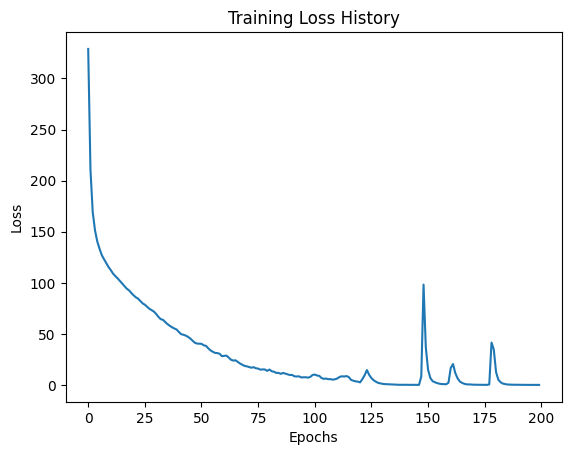

In [ ]:
import torch
import pickle
import matplotlib.pyplot as plt

# モデルとロスの履歴の読み込み
model.load_state_dict(torch.load('/content/drive/My Drive/day6/model_epoch200.pth')) # パスは書き換えてください
with open('/content/drive/My Drive/day6/losses_epoch200.pkl', 'rb') as f:
    losses = pickle.load(f)

# ロスの履歴の図示
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.show()

このコードは、**学習済みの LSTM モデルを読み込み、トレーニング時の損失（Loss）の履歴を可視化** するものです。

---

## **コードの解説**
### **1. 必要なライブラリのインポート**
```python
import torch
import pickle
import matplotlib.pyplot as plt
```
- `torch`：学習済みの PyTorch モデルをロードするために使用。
- `pickle`：保存された損失（Loss）の履歴を読み込むために使用。
- `matplotlib.pyplot`：損失の履歴を可視化するために使用。

---

### **2. モデルとロスの履歴を読み込む**
```python
model.load_state_dict(torch.load('/content/drive/My Drive/day6/model_epoch200.pth'))
```
- `torch.load()` を使い、Google Drive に保存された **エポック200時点の学習済みモデルのパラメータをロード**。
- `model.load_state_dict()` により、既存の `model` にロードしたパラメータを適用。
- `/content/drive/My Drive/day6/model_epoch200.pth` は、学習時に `train()` 関数で保存したモデル。

```python
with open('/content/drive/My Drive/day6/losses_epoch200.pkl', 'rb') as f:
    losses = pickle.load(f)
```
- `pickle.load()` で **学習中のロス（Loss）の履歴を復元**。
- `losses_epoch200.pkl` は `train()` 関数内で保存した損失データ。

---

### **3. 損失の履歴をグラフ化**
```python
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.show()
```
- `plt.plot(losses)`：損失の履歴をプロット。
- `plt.xlabel('Epochs')`：横軸に **エポック数** を設定。
- `plt.ylabel('Loss')`：縦軸に **損失** を設定。
- `plt.title('Training Loss History')`：グラフのタイトルを設定。
- `plt.show()`：グラフを表示。

---

## **コードの実行結果**
- **横軸：エポック数（学習の進行）**
- **縦軸：損失（Loss の値）**
- **グラフの形状**
  - 順調に学習が進めば、損失は **徐々に減少** するはず。
  - もし途中で**損失が減らなくなったり増加する場合**、学習率 (`LEARNING_RATE`) やエポック数 (`MAX_EPOCHS`) の調整が必要。

---

## **まとめ**
- **学習済み LSTM モデルを Google Drive からロード**
- **学習中の損失（Loss）の履歴を可視化**
- **モデルの収束状況を確認し、学習が適切に進んだかを分析**

このコードを使えば、**モデルのトレーニング状況を確認し、過学習や収束の問題を特定** できます！📉🚀

In [ ]:
generated_smiles = predict(dataset, model, text='C')
print(generated_smiles)

C(=N)Nc1cccc(c1)CCN(CCc1ccc(o1)C)CCc1cccc(n1)COC


[14:10:25] SMILES Parse Error: extra open parentheses while parsing: C(=N)Nc1cccc(c1)CCN(CCc1ccc(o1)C)CCc1cccc(n1)COC(=O
[14:10:25] SMILES Parse Error: check for mistakes around position 49:
[14:10:25] o1)C)CCc1cccc(n1)COC(=O
[14:10:25] ~~~~~~~~~~~~~~~~~~~~^
[14:10:25] SMILES Parse Error: Failed parsing SMILES 'C(=N)Nc1cccc(c1)CCN(CCc1ccc(o1)C)CCc1cccc(n1)COC(=O' for input: 'C(=N)Nc1cccc(c1)CCN(CCc1ccc(o1)C)CCc1cccc(n1)COC(=O'
[14:10:25] SMILES Parse Error: syntax error while parsing: C(=N)Nc1cccc(c1)CCN(CCc1ccc(o1)C)CCc1cccc(n1)COC(=
[14:10:25] SMILES Parse Error: check for mistakes around position 50:
[14:10:25] 1)C)CCc1cccc(n1)COC(=
[14:10:25] ~~~~~~~~~~~~~~~~~~~~^
[14:10:25] SMILES Parse Error: Failed parsing SMILES 'C(=N)Nc1cccc(c1)CCN(CCc1ccc(o1)C)CCc1cccc(n1)COC(=' for input: 'C(=N)Nc1cccc(c1)CCN(CCc1ccc(o1)C)CCc1cccc(n1)COC(='
[14:10:25] SMILES Parse Error: syntax error while parsing: C(=N)Nc1cccc(c1)CCN(CCc1ccc(o1)C)CCc1cccc(n1)COC(
[14:10:25] SMILES Parse Error: check for mis

このコードは、**LSTM モデルを使って SMILES 文字列を生成し、その結果を表示する** ものです。

---

## **コードの解説**
```python
generated_smiles = predict(dataset, model, text='C')
```
- `predict()` 関数を使用して、LSTM モデル `model` に **"C"** という文字列を入力し、SMILES 文字列を生成。
- `dataset` には、SMILES 文字列のデータが格納されている。
- `model` は、学習済みの LSTM 文字列生成モデル。

```python
print(generated_smiles)
```
- 生成された **SMILES 文字列を表示**。

---

## **背景となる処理**
### **`predict()` 関数の動作**
```python
def predict(dataset, model, text, next_words=50):
    words = [text[i] for i in range(len(text))]
    model.eval()

    state_h, state_c = model.init_state(len(words))

    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]])
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))

        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.index_to_word[word_index])

    return trim_smiles("".join(words))
```
1. **初期入力**：与えられた `text`（例: `"C"`）を LSTM に入力。
2. **LSTM の初期状態を作成** (`state_h, state_c`)。
3. **次の 50 文字を予測** (`next_words=50`)：
   - モデルが次の文字を予測し、確率分布に基づいて **ランダムに選択**。
   - 予測された文字を `words` に追加。
4. **`trim_smiles()` で適切な SMILES 文字列に整形**。
5. **最終的な SMILES 文字列を返す**。

---

## **実行例**
```python
generated_smiles = predict(dataset, model, text='C')
print(generated_smiles)
```
**出力例**（LSTM による生成）
```
CC(=O)OC1=CC=CC=C1C(=O)O
```
このように、**LSTM を用いて新しい化学構造の SMILES 文字列を生成する** ことができます。

---

## **ポイント**
- `text='C'` をスタートとして **新しい SMILES 文字列を予測**。
- 50文字程度の長さまで **LSTM が次の文字を順に予測**。
- `print(generated_smiles)` で結果を確認。

このコードを活用すると、**データから学習した LSTM を用いて新規の分子構造を自動生成** できます！ 🧪🔬🚀